In [1120]:
import torch
from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np

In [1163]:
class GaussianRBF(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        #Definition and initialization of centers and scales
        self.mus = torch.nn.Parameter(torch.ones(output_dim, input_dim))
        self.log_sigmas = torch.nn.Parameter(torch.ones(output_dim))
        self.reset_parameters()
        print(self.log_sigmas)
        
    def reset_parameters(self):
        nn.init.uniform_(self.mus, 0, 1)
        nn.init.constant_(self.log_sigmas, -2)
        
    def forward(self, x):
        d_scaled = ((x[:,None,:] - self.mus[None,:,:])/torch.exp(self.log_sigmas[None,:,None]))
        return torch.exp(-(torch.linalg.vector_norm(d_scaled, axis=-1, ord=2))**2/2)

In [1164]:
N_sensornodes = 1000
x_sensor, y_sensor = np.mgrid[0:1:np.sqrt(N_sensornodes)*1j, 0:1:np.sqrt(N_sensornodes)*1j]
sensornodes_Omega = np.vstack([x_sensor.ravel(), y_sensor.ravel()]).T

In [1165]:
sensornodes_Omega.shape

(961, 2)

In [1166]:
model = GaussianRBF(1,1)

Parameter containing:
tensor([-2.], requires_grad=True)


In [1167]:
f = model(torch.tensor(sensornodes_Omega))
f = f.detach().numpy()

In [1168]:
f.shape

(961, 1)

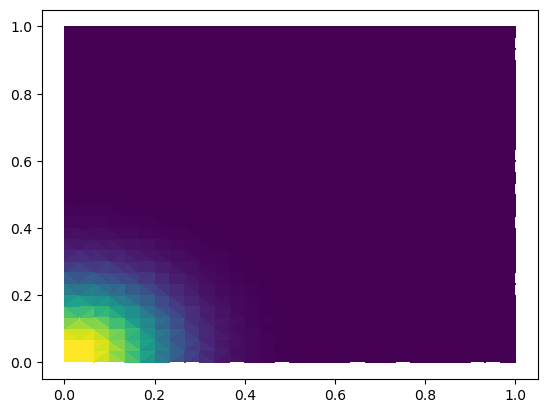

In [1169]:
plt.tripcolor(sensornodes_Omega[:,0], sensornodes_Omega[:,1], f[:,0])

In [1170]:
model = GaussianRBF(2,2)

Parameter containing:
tensor([-2., -2.], requires_grad=True)


In [1171]:
f = model(torch.tensor(sensornodes_Omega))
f = f.detach().numpy()

In [1172]:
f.shape

(961, 2)

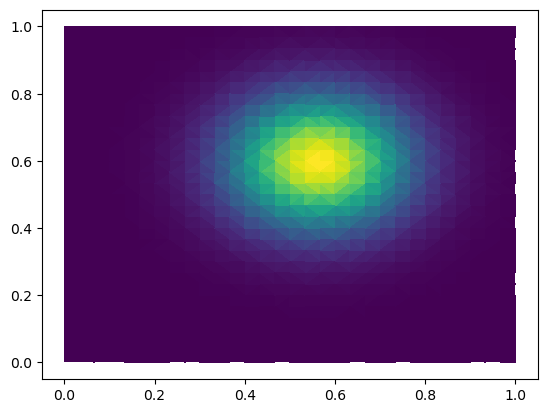

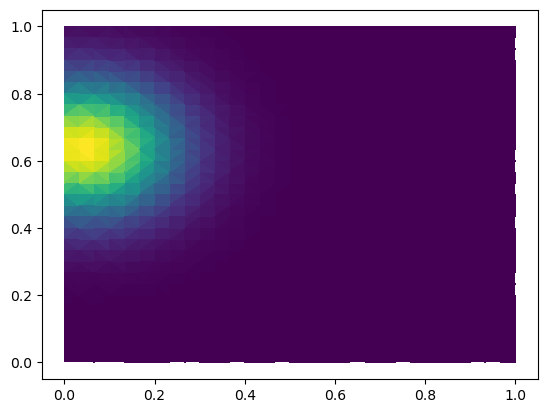

In [1173]:
for i in range(f.shape[-1]):
    plt.tripcolor(sensornodes_Omega[:,0], sensornodes_Omega[:,1], f[:,i])
    plt.show()

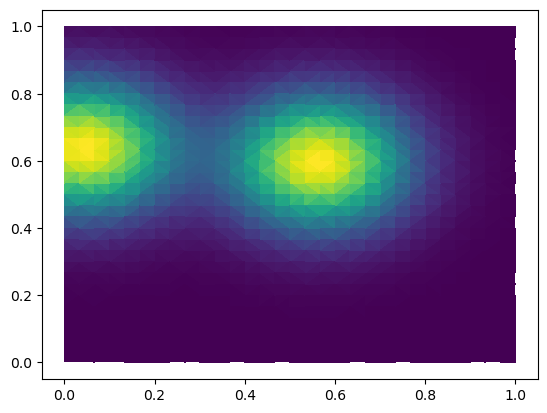

In [1174]:
plt.tripcolor(sensornodes_Omega[:,0], sensornodes_Omega[:,1], np.sum(f, axis=-1))
plt.show()

In [944]:
output = model.forward(torch.rand(2))

IndexError: too many indices for tensor of dimension 1

In [ ]:
output.shape

torch.Size([72])

In [ ]:
a = torch.rand(2)
a
torch.tile(a,(10,1)).shape

torch.Size([10, 2])

In [ ]:
class NLBranchNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=4, stride=1))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.BatchNorm2d(num_features=1))
        self.layers.append(nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=4, stride=1))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.BatchNorm2d(num_features=1))
        self.layers.append(nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=2))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=2))
        self.layers.append(nn.ReLU())

    def forward(self, x):
        for layer in self.layers:
            print(x.shape)
            x = layer(x)
        return x

In [ ]:
output = NLBranchNet().forward(torch.rand((100,1,12,12)))

torch.Size([100, 1, 12, 12])
torch.Size([100, 1, 15, 15])
torch.Size([100, 1, 15, 15])
torch.Size([100, 1, 15, 15])
torch.Size([100, 1, 18, 18])
torch.Size([100, 1, 18, 18])
torch.Size([100, 1, 18, 18])
torch.Size([100, 1, 36, 36])
torch.Size([100, 1, 36, 36])
torch.Size([100, 1, 72, 72])


In [757]:
output.shape

torch.Size([100, 1, 72, 72])

In [758]:
class LBranchNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [759]:
model = LBranchNet(144, 72)

In [760]:
model(torch.rand(144))

tensor([-0.2208, -0.3801,  0.0346, -0.7610, -0.0551, -0.2607, -0.0874, -0.4528,
         0.6527,  0.3847,  0.0674,  0.3899,  0.0083, -0.2162, -0.2003, -0.3104,
        -0.1567, -0.2502,  0.1379, -0.0560, -0.0787, -0.0150,  0.2375,  0.1300,
        -0.3511, -0.6236,  0.0453, -0.1793, -0.0550,  0.4397,  0.3087, -0.2188,
         0.0808, -0.2499, -0.1281,  0.1982,  0.0542, -0.4723,  0.3466,  0.1269,
        -0.3579,  0.1775, -0.1073,  0.4635,  0.1717, -0.5986,  0.3979,  0.4391,
         0.1440,  0.0785,  0.3687, -0.2216,  0.0344,  0.1638, -0.5759,  0.0074,
        -0.4512,  0.1913,  0.3243,  0.3164, -0.0403,  0.4436, -0.3114, -0.1465,
        -0.3951,  0.4623,  0.2161, -0.5391,  0.2966, -0.2133, -0.1800, -0.2483],
       grad_fn=<AddBackward0>)

In [734]:
class VarMiON(pl.LightningModule):
    def __init__(self, params):
        super().__init__()
        self.hparams.update(params['hparams'])
        self.NLBranch = NLBranchNet()
        self.LBranch = LBranchNet(144,72)
        self.Trunk = GaussianRBF(2,72)
        
    def forward(self, theta, F, N, x):
        NLBranch = self.NLBranch.forward(theta)
        NLBranch = NLBranch.reshape((NLBranch.shape[0], NLBranch.shape[2], NLBranch.shape[3]))
        LBranch = self.LBranch.forward(F) + self.LBranch.forward(N)
        Branch = torch.einsum('nij,nj->ni', NLBranch, LBranch)
        Trunk = self.Trunk.forward(x)
        u_hat = torch.einsum('ni,ni->n', Branch, Trunk)
        return u_hat

In [735]:
params = {}
params['hparams'] = {}
model = VarMiON(params)

In [736]:
theta = torch.rand((100,1,12,12))
F = torch.rand(100,144)
N = torch.rand(100,144)
x = torch.rand(100,2)

In [737]:
model(theta, F, N, x)

tensor([-12.6339, -12.0574,   5.4279, -16.7512,  -7.2277,   6.2317, -38.6222,
         -9.1250, -46.4326,  31.6748,  15.4189, -27.3362,  14.0615,   9.1573,
          2.3800,  -1.1785, -38.8013,  -0.3794, -30.2249,  13.4508,   6.2006,
         -9.8372,  -2.7328,  -0.4309, -11.8884,  12.5995,  16.0303, -21.7925,
        -15.0602,  -6.9806,   0.9179,  -5.7771,  38.1931, -24.8681,  -4.4224,
         -4.3838,  22.1341, -14.1829,  30.7786,  -8.0878, -34.1088,   1.5166,
         23.9353,  25.5672,   6.6319, -38.1930,  -5.3510,  -0.7043,  -3.3233,
         14.3378, -32.2201, -23.3337,  12.7945,   1.2699,   8.5736,   2.1406,
          9.6381, -24.3608, -27.9313, -28.2332, -33.0071, -51.0575, -22.4024,
         15.9460,   2.9953,  -5.9505,   9.7180,  26.8519,  12.6020, -34.0308,
         14.5472, -24.3554,  21.3180, -39.2854,   0.6173,  43.7170, -30.2473,
        -35.4772, -42.3603,  20.8130,  23.4532, -32.3357,  15.6716,   6.3320,
         52.4780,   1.0385, -18.1282,  -5.7017, -42.1263,  53.79